In [10]:
!rm -rf sample_data/  
from google.colab import drive
drive.mount('/content/drive')
!cp -r /content/drive/MyDrive/740_deeplearning/standard/* /content/
!cp -r /content/Anomaly_detection/PANDA/code/* /content/
!pip install faiss-gpu

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
cp: cannot open '/content/drive/MyDrive/740_deeplearning/standard/AA_results_cifar100_L2/log_file.gdoc' for reading: Operation not supported
cp: cannot open '/content/drive/MyDrive/740_deeplearning/standard/AA_results_cifar100_Linf/log_file.gdoc' for reading: Operation not supported
cp: cannot open '/content/drive/MyDrive/740_deeplearning/standard/AA_results_cifar10_L2/log_file.gdoc' for reading: Operation not supported
cp: cannot open '/content/drive/MyDrive/740_deeplearning/standard/AA_results_cifar10_Linf/log_file.gdoc' for reading: Operation not supported
cp: cannot open '/content/drive/MyDrive/740_deeplearning/PANDA/requirements.gdoc' for reading: Operation not supported
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [11]:
import torch
import torch.nn as nn

try:
    from torch.hub import load_state_dict_from_url
except ImportError:
    from torch.utils.model_zoo import load_url as load_state_dict_from_url

__all__ = ['ResNet']


model_urls = {
    'resnet18': 'https://download.pytorch.org/models/resnet18-5c106cde.pth',
}


def conv3x3(in_planes, out_planes, stride=1, groups=1, dilation=1):
    """3x3 convolution with padding"""
    return nn.Conv2d(in_planes, out_planes, kernel_size=3, stride=stride,
                     padding=dilation, groups=groups, bias=False, dilation=dilation)


def conv1x1(in_planes, out_planes, stride=1):
    """1x1 convolution"""
    return nn.Conv2d(in_planes, out_planes, kernel_size=1, stride=stride, bias=False)


class BasicBlock(nn.Module):
    expansion = 1

    def __init__(self, inplanes, planes, stride=1, downsample=None, groups=1,
                 base_width=64, dilation=1, norm_layer=None):
        super(BasicBlock, self).__init__()
        if norm_layer is None:
            norm_layer = nn.BatchNorm2d
        if groups != 1 or base_width != 64:
            raise ValueError('BasicBlock only supports groups=1 and base_width=64')
        if dilation > 1:
            raise NotImplementedError("Dilation > 1 not supported in BasicBlock")
        self.conv1 = conv3x3(inplanes, planes, stride)
        self.bn1 = norm_layer(planes)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = conv3x3(planes, planes)
        self.bn2 = norm_layer(planes)
        self.downsample = downsample
        self.stride = stride

    def forward(self, x):
        identity = x
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)
        out = self.conv2(out)
        out = self.bn2(out)
        if self.downsample is not None:
            identity = self.downsample(x)
        out += identity
        out = self.relu(out)
        return out

class ResNet(nn.Module):

    def __init__(self, block, layers, num_classes=1000, zero_init_residual=False,
                 groups=1, width_per_group=64, replace_stride_with_dilation=None,
                 norm_layer=None):
        super(ResNet, self).__init__()
        if norm_layer is None:
            norm_layer = nn.BatchNorm2d
        self._norm_layer = norm_layer

        self.inplanes = 64
        self.dilation = 1
        if replace_stride_with_dilation is None:
            replace_stride_with_dilation = [False, False, False]
        if len(replace_stride_with_dilation) != 3:
            raise ValueError("replace_stride_with_dilation should be None "
                             "or a 3-element tuple, got {}".format(replace_stride_with_dilation))
        self.groups = groups
        self.base_width = width_per_group
        self.conv1 = nn.Conv2d(3, self.inplanes, kernel_size=7, stride=2, padding=3,
                               bias=False)
        self.bn1 = norm_layer(self.inplanes)
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        self.layer1 = self._make_layer(block, 64, layers[0])
        self.layer2 = self._make_layer(block, 128, layers[1], stride=2,
                                       dilate=replace_stride_with_dilation[0])
        self.layer3 = self._make_layer(block, 256, layers[2], stride=2,
                                       dilate=replace_stride_with_dilation[1])
        self.layer4 = self._make_layer(block, 512, layers[3], stride=2,
                                       dilate=replace_stride_with_dilation[2])
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(512 * block.expansion, num_classes)

        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
            elif isinstance(m, (nn.BatchNorm2d, nn.GroupNorm)):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)

    def _make_layer(self, block, planes, blocks, stride=1, dilate=False):
        norm_layer = self._norm_layer
        downsample = None
        previous_dilation = self.dilation
        if dilate:
            self.dilation *= stride
            stride = 1
        if stride != 1 or self.inplanes != planes * block.expansion:
            downsample = nn.Sequential(conv1x1(self.inplanes, planes * block.expansion, stride),
                norm_layer(planes * block.expansion), )

        layers = []
        layers.append(block(self.inplanes, planes, stride, downsample, self.groups,
                            self.base_width, previous_dilation, norm_layer))
        self.inplanes = planes * block.expansion
        for _ in range(1, blocks):
            layers.append(block(self.inplanes, planes, groups=self.groups,
                                base_width=self.base_width, dilation=self.dilation,
                                norm_layer=norm_layer))

        return nn.Sequential(*layers)

    def _forward_impl(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)
        x = self.avgpool(x)
        avg = torch.flatten(x, 1)
        x = self.fc(avg)

        return x.squeeze(), avg.squeeze()

    def forward(self, x):
        return self._forward_impl(x)

    def freeze_parameters(self, freeze_layer4=False, train_fc=False):
        for p in self.conv1.parameters():
            p.requires_grad = False
        for p in self.bn1.parameters():
            p.requires_grad = False
        for p in self.layer1.parameters():
            p.requires_grad = False
        for p in self.layer2.parameters():
            p.requires_grad = False
        for p in self.fc.parameters():
            p.requires_grad = False

        if freeze_layer4:
            for p in self.layer4.parameters():
                p.requires_grad = False
        if train_fc:
            for p in self.fc.parameters():
                p.requires_grad = True

        counter = 0
        for p in self.parameters():
            if p.requires_grad:
                counter += 1
        print('n of req grad params: {}, n of total parameters: {}'.format(counter, len(list(self.parameters()))))

def _resnet(arch, block, layers, pretrained, progress, **kwargs):
    model = ResNet(block, layers, **kwargs)
    if pretrained:
        state_dict = load_state_dict_from_url(model_urls[arch],
                                              progress=progress)
        model.load_state_dict(state_dict)
    return model


def resnet18(pretrained=False, progress=True, **kwargs):
    return _resnet('resnet18', BasicBlock, [2, 2, 2, 2], pretrained, progress,
                   **kwargs)

In [ ]:
import numpy as np
import torch
import os
import faiss
from sklearn.metrics import roc_auc_score
import torch.optim as optim
from sklearn.preprocessing import label_binarize
from losses import CompactnessLoss
from copy import deepcopy
import torchvision
from tqdm import tqdm
import torchvision.transforms as transforms

transform_color = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomCrop(32, padding=4),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
])


def log_print(log_path, *args, **kwargs):
    with open(log_path, 'a') as log_file:
        print(*args, file=log_file, **kwargs)
    print(*args, **kwargs)

def train_model(model, train_loader, test_loader, adv_test_loader, adv_labels, device, log_path):
    model.eval()
    adv_auc, feature_space = get_score(model, device, test_loader, adv_test_loader, adv_labels)
    log_print(log_path, 'Epoch: {}, Adversarial AUROC is: {}'.format(0, adv_auc))
    optimizer = optim.SGD(model.parameters(), lr=lr, weight_decay=0.00005, momentum=0.9)
    center = torch.FloatTensor(feature_space).mean(dim=0)
    criterion = CompactnessLoss(center.to(device))
    for epoch in range(epochs):
        running_loss = run_epoch(model, train_loader, optimizer, criterion, device)
        log_print(log_path, 'Epoch: {}, Loss: {}'.format(epoch + 1, running_loss))
        adv_auc, _ = get_score(model, device, test_loader, adv_test_loader, adv_labels)
        log_print(log_path, 'Epoch: {}, Adversarial AUROC is: {}'.format(epoch + 1, adv_auc))
        log_print(log_path, '===============================================================')


def run_epoch(model, train_loader, optimizer, criterion, device):
  running_loss = 0.0
  for i, (imgs, _) in enumerate(train_loader):
      images = imgs.to(device)
      optimizer.zero_grad()
      _, features = model(images)
      loss = criterion(features)
      loss.backward()
      torch.nn.utils.clip_grad_norm_(model.parameters(), 1e-3)
      optimizer.step()
      running_loss += loss.item()
  return running_loss / (i + 1)

def knn_score(train_set, test_set, n_neighbours=2):
  index = faiss.IndexFlatL2(train_set.shape[1])
  index.add(train_set)
  D, _ = index.search(test_set, n_neighbours)
  return np.sum(D, axis=1)

def get_score(model, device, train_loader, test_loader, adv_labels):
  train_feature_space = []
  with torch.no_grad():
      for (imgs, _) in tqdm(train_loader, desc='Train set feature extracting'):
          imgs = imgs.to(device)
          _, features = model(imgs)
          train_feature_space.append(features)
      train_feature_space = torch.cat(train_feature_space, dim=0).contiguous().cpu().numpy()
  test_feature_space = []
  with torch.no_grad():
      for (imgs, _) in tqdm(test_loader, desc='Test set feature extracting'):
          imgs = imgs.to(device)
          _, features = model(imgs)
          test_feature_space.append(features)
      test_feature_space = torch.cat(test_feature_space, dim=0).contiguous().cpu().numpy()
  
  n_classes = len(np.unique(adv_labels))
  binary_adv_labels = label_binarize(adv_labels, classes=range(n_classes))
  
  distances = knn_score(train_feature_space, test_feature_space)
  
  aucs = []
  for i in range(n_classes):
      auc = roc_auc_score(binary_adv_labels[:, i], distances)
      aucs.append(auc)
  
  return aucs, train_feature_space

def freeze_parameters(model, train_fc=False):
    for p in model.conv1.parameters():
        p.requires_grad = False
    for p in model.bn1.parameters():
        p.requires_grad = False
    for p in model.layer1.parameters():
        p.requires_grad = False
    for p in model.layer2.parameters():
        p.requires_grad = False
    if not train_fc:
        for p in model.fc.parameters():
            p.requires_grad = False

def main(dataset, epochs, lr, batch_size, log_path):
  print(f'Dataset: {dataset}, LR: {lr}')
  # Set up the device and model
  device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
  model = resnet18(pretrained=True, progress=True)
  # Change the last layer
  num_classes = 100
  model.fc = torch.nn.Linear(512, num_classes)
  model = model.to(device)
  freeze_parameters(model)
  train_loader, test_loader, adv_test_loader, adv_labels = get_loaders(dataset, batch_size)
  train_model(model, train_loader, test_loader, adv_test_loader, adv_labels, device, log_path)

def get_loaders(dataset, batch_size):
  ds = torchvision.datasets.CIFAR100
  trainset = ds(root='data', train=True, download=True, transform=transform_color)
  testset  = ds(root='data', train=False, download=True, transform=transform_color)
  train_loader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True, num_workers=2, drop_last=False)
  test_loader  = torch.utils.data.DataLoader(testset, batch_size=batch_size, shuffle=False, num_workers=2, drop_last=False)
  
  # Load the adversarial dataset
  adv_data_path = '/content/standard/AA_results_cifar100_L2/aa_standard_1_10000_eps_0.03137.pth'
  adv_data = torch.load(adv_data_path)
  adv_images = adv_data['adv_complete']
  # Use the labels of the CIFAR-100 test set as the adversarial labels
  adv_labels = test_loader.dataset.targets
  adv_testset = torch.utils.data.TensorDataset(adv_images, torch.tensor(adv_labels))
  adv_test_loader = torch.utils.data.DataLoader(adv_testset, batch_size=batch_size, shuffle=False, num_workers=2, drop_last=False)
  return train_loader, test_loader, adv_test_loader, adv_labels

if __name__ == "__main__":
    dataset = 'cifar100'
    epochs = 15
    lr = 1e-2
    batch_size = 512
    norm = 'L2'

    save_dir = f'/content/drive/MyDrive/740_deeplearning/Anomaly_detection/PANDA/{dataset}_{norm}'
    os.makedirs(save_dir, exist_ok=True)
    log_path = os.path.join(save_dir, 'logs.txt')
    main(dataset, epochs, lr, batch_size, log_path)


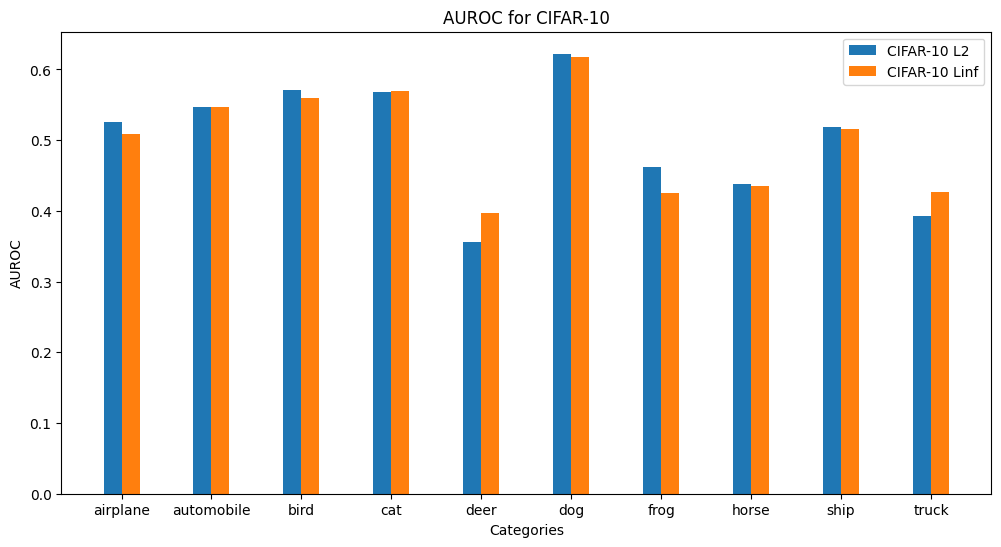

In [32]:
AUROC_CIFAR10_L2= [0.525527388888889, 0.5463271111111111, 0.5707646666666667, 0.567635611111111, 0.3558608888888889, 0.6221596111111111, 0.4616548888888889, 0.43824822222222226, 0.5189211111111112, 0.3929005]
AUROC_CIFAR10_Linf= [0.5086179444444444, 0.5473396666666667, 0.559064611111111, 0.5689000555555557, 0.39646616666666673, 0.6179662222222221, 0.42458933333333326, 0.43571966666666667, 0.5152284444444445, 0.42610788888888895]

AUROC_CIFAR100_L2= [0.8436707070707071, 0.5685813131313131, 0.5875515151515152, 0.3592121212121212, 0.34663333333333335, 0.39137171717171715, 0.5815924242424242, 0.4807393939393939, 0.36935656565656566, 0.5318242424242424, 0.7302979797979797, 0.4708606060606061, 0.4107717171717172, 0.41383939393939395, 0.40031212121212123, 0.3916616161616161, 0.5479818181818181, 0.38895353535353533, 0.5241156565656566, 0.38661464646464644, 0.43170151515151517, 0.4831494949494949, 0.7042464646464647, 0.5599813131313132, 0.49220101010101014, 0.4282373737373737, 0.5429969696969696, 0.36868383838383834, 0.5404000000000001, 0.3909, 0.656860606060606, 0.3954434343434343, 0.5618565656565657, 0.4233893939393939, 0.36254949494949495, 0.5505469696969696, 0.5763616161616162, 0.38205252525252525, 0.3268075757575758, 0.7920868686868687, 0.485860101010101, 0.4672454545454545, 0.2474050505050505, 0.35968282828282827, 0.4145116161616162, 0.5435010101010102, 0.4343060606060606, 0.5626474747474747, 0.38380202020202014, 0.5809656565656565, 0.4461813131313131, 0.398730303030303, 0.5447818181818181, 0.777260606060606, 0.4938545454545455, 0.43320757575757574, 0.6559525252525253, 0.6472666666666667, 0.4041368686868687, 0.539769696969697, 0.5417348484848485, 0.7587025252525252, 0.6503373737373738, 0.4155671717171717, 0.4225934343434344, 0.4793505050505051, 0.4435575757575758, 0.5594636363636363, 0.4573242424242424, 0.5555121212121212, 0.6246878787878787, 0.5677606060606061, 0.5004808080808081, 0.6641767676767676, 0.3622116161616162, 0.3273868686868687, 0.6476979797979798, 0.5029611111111111, 0.5103383838383838, 0.5699176767676768, 0.3934262626262626, 0.40112929292929295, 0.7573919191919192, 0.7099570707070708, 0.4167949494949495, 0.3276353535353535, 0.49854242424242423, 0.44006060606060604, 0.4380151515151515, 0.4196757575757576, 0.4281484848484849, 0.4363727272727273, 0.5729060606060605, 0.5456494949494949, 0.4016828282828283, 0.5898373737373738, 0.5607742424242425, 0.4470924242424243, 0.5534535353535354, 0.5822262626262626]
AUROC_CIFAR100_Linf=[0.8364707070707071, 0.5319050505050505, 0.5935949494949495, 0.38820303030303027, 0.34715050505050504, 0.39585050505050506, 0.6220919191919191, 0.5102373737373738, 0.3472191919191919, 0.5310575757575757, 0.7589737373737374, 0.48166767676767674, 0.41057373737373737, 0.4160212121212121, 0.4537171717171717, 0.40226262626262627, 0.5827737373737374, 0.35815353535353533, 0.5142843434343434, 0.37807777777777773, 0.4297434343434343, 0.4645828282828283, 0.7118010101010102, 0.521090909090909, 0.5438909090909091, 0.3951313131313131, 0.584819191919192, 0.37173636363636364, 0.5468151515151515, 0.42568232323232325, 0.6145212121212121, 0.39425, 0.5663454545454545, 0.3897590909090909, 0.38922525252525253, 0.5616929292929294, 0.5615414141414141, 0.36575858585858584, 0.304349494949495, 0.792578787878788, 0.49900808080808073, 0.4188161616161616, 0.271489898989899, 0.3386469696969697, 0.4289313131313131, 0.5804949494949494, 0.44438080808080804, 0.5699626262626263, 0.396339393939394, 0.5208393939393939, 0.4754621212121213, 0.4088252525252526, 0.500040404040404, 0.7979323232323232, 0.5356989898989899, 0.41623787878787877, 0.6185949494949495, 0.6608262626262627, 0.4076308080808081, 0.5203252525252525, 0.36682020202020205, 0.8031646464646465, 0.6841358585858586, 0.4313636363636363, 0.44928888888888896, 0.4821146464646464, 0.4600383838383839, 0.5547040404040404, 0.397700505050505, 0.5133181818181818, 0.6645500000000001, 0.43884040404040414, 0.5123944444444444, 0.6680383838383839, 0.37969797979797976, 0.32807878787878786, 0.6682191919191919, 0.48501363636363637, 0.5194646464646464, 0.5389525252525253, 0.38407979797979797, 0.4317969696969696, 0.7657747474747474, 0.7237484848484849, 0.4167232323232324, 0.31163989898989897, 0.5226939393939394, 0.4638060606060606, 0.437710101010101, 0.4168181818181818, 0.41021919191919193, 0.41626969696969696, 0.6080949494949496, 0.5259898989898989, 0.4072338383838384, 0.587161111111111, 0.5330383838383839, 0.43460303030303027, 0.5871762626262627, 0.6634373737373737]


import matplotlib.pyplot as plt

def barplot_auroc(auroc_cifar10_l2, auroc_cifar10_linf):
    plt.figure(figsize=(12, 6))

    cifar10_categories = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
    x = range(len(cifar10_categories))

    plt.bar(x, auroc_cifar10_l2, width=0.2, label='CIFAR-10 L2')
    plt.bar([i + 0.2 for i in x], auroc_cifar10_linf, width=0.2, label='CIFAR-10 Linf')

    plt.xticks([i + 0.1 for i in x], cifar10_categories)
    plt.xlabel('Categories')
    plt.ylabel('AUROC')
    plt.title('AUROC for CIFAR-10')
    plt.legend()
    plt.savefig('/content/drive/MyDrive/740_deeplearning/Anomaly_detection/PANDA/CIFAR10', dpi=300, bbox_inches='tight')
    plt.show()

barplot_auroc(AUROC_CIFAR10_L2, AUROC_CIFAR10_Linf)




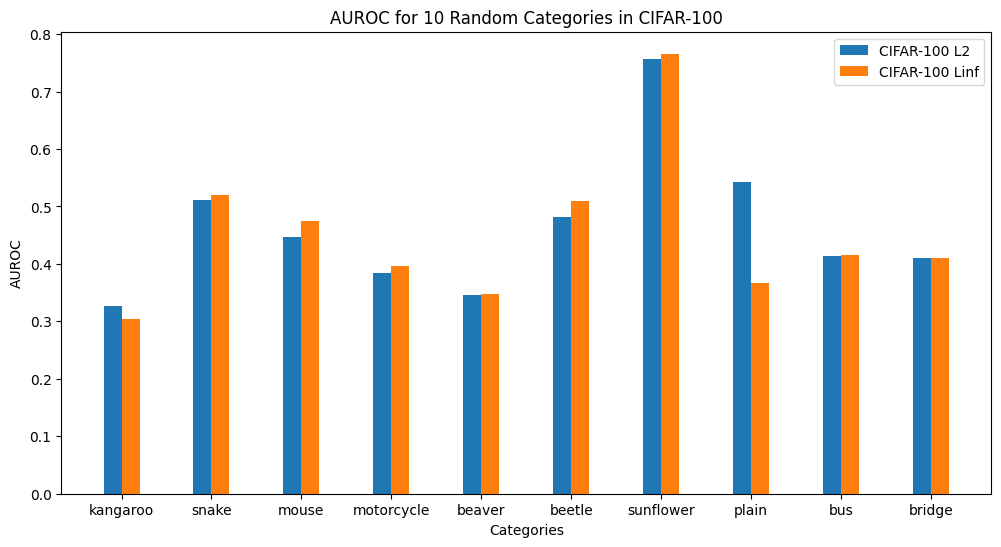

In [33]:
import matplotlib.pyplot as plt
import random

def barplot_auroc(auroc_cifar100_l2, auroc_cifar100_linf):
    plt.figure(figsize=(12, 6))

    cifar100_categories = ['apple', 'aquarium_fish', 'baby', 'bear', 'beaver', 'bed', 'bee', 'beetle', 'bicycle', 'bottle', 'bowl', 'boy', 'bridge', 'bus', 'butterfly', 'camel', 'can', 'castle', 'caterpillar', 'cattle', 'chair', 'chimpanzee', 'clock', 'cloud', 'cockroach', 'couch', 'crab', 'crocodile', 'cup', 'dinosaur', 'dolphin', 'elephant', 'flatfish', 'forest', 'fox', 'girl', 'hamster', 'house', 'kangaroo', 'computer_keyboard', 'lamp', 'lawn_mower', 'leopard', 'lion', 'lizard', 'lobster', 'man', 'maple_tree', 'motorcycle', 'mountain', 'mouse', 'mushroom', 'oak_tree', 'orange', 'orchid', 'otter', 'palm_tree', 'pear', 'pickup_truck', 'pine_tree', 'plain', 'plate', 'poppy', 'porcupine', 'possum', 'rabbit', 'raccoon', 'ray', 'road', 'rocket', 'rose', 'sea', 'seal', 'shark', 'shrew', 'skunk', 'skyscraper', 'snail', 'snake', 'spider', 'squirrel', 'streetcar', 'sunflower', 'sweet_pepper', 'table', 'tank', 'telephone', 'television', 'tiger', 'tractor', 'train', 'trout', 'tulip', 'turtle', 'wardrobe', 'whale', 'willow_tree', 'wolf', 'woman', 'worm']

    random_indices = random.sample(range(len(cifar100_categories)), 10)
    selected_categories = [cifar100_categories[i] for i in random_indices]
    selected_auroc_l2 = [auroc_cifar100_l2[i] for i in random_indices]
    selected_auroc_linf = [auroc_cifar100_linf[i] for i in random_indices]

    x = range(len(selected_categories))

    plt.bar(x, selected_auroc_l2, width=0.2, label='CIFAR-100 L2')
    plt.bar([i + 0.2 for i in x], selected_auroc_linf, width=0.2, label='CIFAR-100 Linf')

    plt.xticks([i + 0.1 for i in x], selected_categories)
    plt.xlabel('Categories')
    plt.ylabel('AUROC')
    plt.title('AUROC for 10 Random Categories in CIFAR-100')
    plt.legend()
    plt.savefig('/content/drive/MyDrive/740_deeplearning/Anomaly_detection/PANDA/CIFAR100', dpi=300, bbox_inches='tight')
    plt.show()

barplot_auroc(AUROC_CIFAR100_L2, AUROC_CIFAR100_Linf)

